# Phase curve analysis of KELT-1b TESS Sectors 17 and 57
## 2. Light curve plots

**Author:** Hannu Parviainen </br>
**Last updated:** 2 Feb 2023

In [1]:
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [91]:
import pandas as pd
import xarray as xa
import seaborn as sb

from arviz.stats.density_utils import _kde_linear as kde

from pytransit.orbits import fold, epoch
from pytransit.utils.downsample import downsample_time_1d

In [3]:
from src.lpf import KELT1LPF
from src.kelt1 import AAOCW, AAPGW

In [4]:
lpf = KELT1LPF()

In [5]:
lpf.ps

[  0 |G| tc             N(μ = 2455914.1628, σ = 0.01)            [    -inf ..      inf],
   1 |G| p              N(μ = 1.217513, σ = 4.5e-05)             [    0.00 ..      inf],
   2 |G| rho            N(μ = 0.5392592032228568, σ = 0.07529312598667542) [    0.00 ..      inf],
   3 |G| b              U(a = 0.0, b = 1.0)                      [    0.00 ..     1.00],
   4 |G| secw           N(μ = 0.0, σ = 1e-06)                    [   -1.00 ..     1.00],
   5 |G| sesw           N(μ = 0.0, σ = 1e-06)                    [   -1.00 ..     1.00],
   6 |P| k2             N(μ = 0.006084, σ = 0.001)               [    0.00 ..      inf],
   7 |G| oev            N(μ = 0.0, σ = 0.09)                     [    -inf ..      inf],
   8 |G| aev_T17        U(a = 0.0, b = 0.001)                    [    0.00 ..      inf],
   9 |G| adb_T17        U(a = 0, b = 1)                          [    0.00 ..      inf],
  10 |G| log10_ted_T17  U(a = -3.0, b = 0.0)                     [    -inf ..      inf],
  11 |G| lo

In [104]:
df.iloc[:,24:30].std()

gp_T17_ln_out      0.107728
gp_T17_ln_in       0.184401
gp_T17_log10_wn    0.002713
gp_T57_ln_out      0.111226
gp_T57_ln_in       0.157257
gp_T57_log10_wn    0.002277
dtype: float64

In [6]:
with xa.load_dataset('results/01_gp_fit.nc') as ds:
    df = pd.DataFrame(ds.mcmc_samples.values.reshape((-1, ds.parameter.size)),
                      columns=ds.parameter)

In [152]:
def predict_baseline(self, pv):
    self.compute_gp(pv)
    residuals = self.fluxes - squeeze(self.lpf.flux_model(pv))[self.mask]
    bl = zeros_like(self.lpf.timea)
    bl[self.mask] = self.gp.predict(residuals, self.times, return_cov=False)
    return 1. + bl

In [153]:
pvs = permutation(df.values)[:400]
pv = df.median().values
fms = lpf.flux_model(pvs)
bls = array([predict_baseline(lpf._lnlikelihood_models[0], pv) for pv in pvs])
#bls = array([lpf._lnlikelihood_models[0].predict_baseline(pv) for pv in pvs])
sl = lpf.lcslices[1]
bls[:, sl] = array([predict_baseline(lpf._lnlikelihood_models[1], pv) for pv in pvs])[:, sl]
#bls[:, sl] = array([lpf._lnlikelihood_models[1].predict_baseline(pv) for pv in pvs])[:, sl]

In [154]:
mbls = lpf.baseline(pvs)

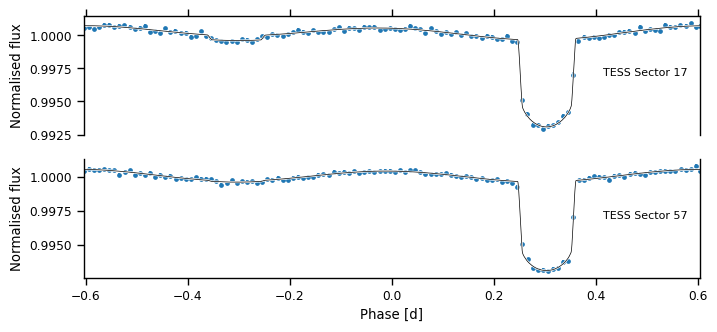

In [156]:
fm, fem, fep = percentile(fms, [50, 16, 84], 0)
bl = median(bls, 0)
aev = df.aev_T17.median()

labels = 'TESS Sector 17', 'TESS Sector 57'

with sb.plotting_context('paper'):
    fig, axs = subplots(2, 1, figsize=(AAPGW, 0.45*AAPGW), sharex='all')

    for i,sl in enumerate(lpf.lcslices):
        ax = axs[i]
        phase = fold(lpf.timea[sl], pv[1], pv[0], 0.25)
        sids = argsort(phase)
        phase = phase[sids]

        pb, fb, eb = downsample_time_1d(phase, lpf.ofluxa[sl][sids] - bl[sl][sids] + 1, 0.01)
        ax.errorbar(pb, fb, eb, fmt='.', zorder=0)
        ax.plot(phase, fm[sl][sids], 'w', lw=1.5, alpha=1)
        ax.plot(phase, fm[sl][sids], 'k', lw=0.5)
        ax.text(0.98, 0.5, labels[i], transform=ax.transAxes, ha='right', size='small')

    sb.despine(ax=axs[0], bottom=True, top=False, right=False)
    sb.despine(ax=axs[1], right=False)

    setp(axs, ylabel='Normalised flux', xlim=pb[[0,-1]])
    setp(axs[0].get_xticklabels(), visible=False)
    setp(axs[1], xlabel='Phase [d]')
    fig.tight_layout()
    fig.subplots_adjust(left=0.11, right=0.98, bottom=0.15, top=0.97)
    fig.savefig('plots/01_phase_curve.pdf')

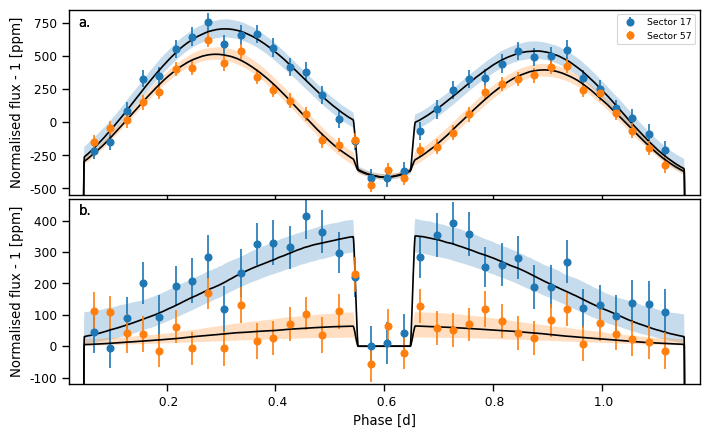

In [158]:
evs = lpf.ellipsoidal_variations(pvs)
dbs = lpf.doppler_boosting(pvs)
fma, fema, fepa = percentile(fms / mbls, [50, 16, 84], 0)
fmb, femb, fepb = percentile(fms / mbls - evs - dbs, [50, 16, 84], 0)
ev = median(evs, 0)
db = median(dbs, 0)
bl = median(bls, 0)
mbl = median(mbls, 0)

labels = 'Sector 17', 'Sector 57'

with sb.plotting_context('paper'):
    fig, axs = subplots(2, 1, figsize=(AAPGW, 0.6*AAPGW), sharex='all')
    for i,sl in enumerate(lpf.lcslices):
        phase = fold(lpf.timea[sl], pv[1], pv[0], 0.5)
        sids = argsort(phase)
        phase = phase[sids]
        
        ax = axs[0]
        pb, fb, eb = downsample_time_1d(phase, lpf.ofluxa[sl][sids]/mbl[sl][sids] - bl[sl][sids] + 1, 0.03)
        ax.errorbar(pb, fb-1, eb, fmt='o', label=labels[i])
        ax.fill_between(phase, fema[sl][sids]-1, fepa[sl][sids]-1, alpha=0.25)
        ax.plot(phase, fma[sl][sids]-1, 'k')
        ax.text(0.015, 0.97, 'a.', transform=ax.transAxes, va='top', ha='left')

        ax = axs[1]
        pb, fb, eb = downsample_time_1d(phase, lpf.ofluxa[sl][sids] - bl[sl][sids] - ev[sl][sids] - db[sl][sids] + 1, 0.03)
        ax.errorbar(pb, fb-1, eb, fmt='o', label=labels[i])
        ax.fill_between(phase, femb[sl][sids]-1, fepb[sl][sids]-1, alpha=0.25)
        ax.plot(phase, fmb[sl][sids]-1, 'k')
        ax.text(0.015, 0.97, 'b.', transform=ax.transAxes, va='top', ha='left')

    [ax.yaxis.set_major_formatter(lambda x, pos: f"{1e6*x:4.0f}") for ax in axs]
    axs[1].xaxis.set_major_formatter(lambda x, pos: f"{x+0.5*pv[1]:4.1f}")

    axs[0].legend(fontsize='x-small')
    setp(axs[0], xlim=(-0.58, 0.58), ylim=(-0.00055, 0.00085), ylabel='Normalised flux - 1 [ppm]',)
    setp(axs[1], xlim=(-0.58, 0.58), ylim=(-0.00012, 0.00047), ylabel='Normalised flux - 1 [ppm]', xlabel='Phase [d]')
    fig.tight_layout()
    
    fig.subplots_adjust(left=0.1, right=0.99, bottom=0.1, top=0.98, hspace=0.02)
    fig.savefig('plots/02_zoomed_phase_curve.pdf')

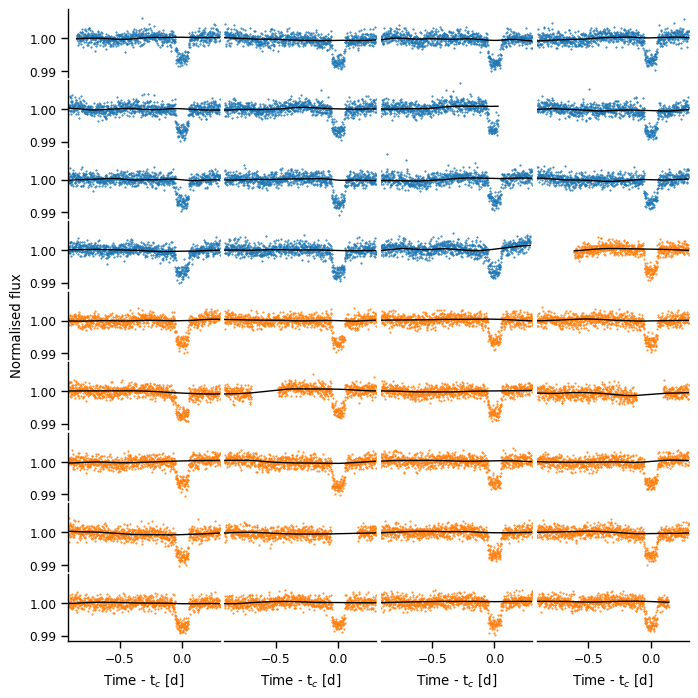

In [113]:
eps = epoch(lpf.timea, pv[0]-0.25*pv[1], pv[1])
ueps = unique(eps)

with sb.plotting_context('paper'):
    fig, axs = subplots(9, 4, figsize=(AAPGW, AAPGW), sharex='all', sharey='all')
    iax = 0
    for i, e in enumerate(ueps):
        m = eps == e
        if m.sum() > 350:
            t0 = pv[0] + pv[1]*ueps[i]
            axs.flat[iax].plot(lpf.timea[m]-t0, lpf.ofluxa[m], '.', c=f"C{lpf.lcids[m][0]}", ms=1, rasterized=True)
            axs.flat[iax].plot(lpf.timea[m]-t0, bl[m], 'k', lw=1)
            iax += 1
setp(axs[-1], xlabel='Time - t$_c$ [d]')
[sb.despine(ax=ax, right=True, left=True, bottom=True) for ax in axs[:-1,1:].flat]
[sb.despine(ax=ax, right=True, bottom=True) for ax in axs[:-1,0].flat]
[sb.despine(ax=ax, right=True, left=True) for ax in axs[-1,1:].flat]
sb.despine(ax=axs[-1, 0])
for ax in axs[:-1, :].flat:
    setp(ax.get_xticklines(), visible=False)
for ax in axs[:, 1:].flat:
    setp(ax.get_yticklines(), visible=False)
setp(axs[4,0], ylabel='Normalised flux')
axs[0,0].autoscale(axis='x', tight=True)
fig.tight_layout()
fig.subplots_adjust(hspace=0.05, wspace=0.03)
fig.savefig('plots/03_light_curves.pdf', dpi=300)

---

<center>&copy;2023 Hannu Parviainen</center>